In [9]:
library(rtracklayer, quietly = T)
library(maftools, quietly = T)
library(TCGAmutations, quietly = T)
library(viridis, quietly = T)
library(ggplot2, quietly = T)
library(dplyr, quietly = T)
np <- reticulate::import("numpy")

WINDOW <- 1e6
PEAK_THRESH <- 2

View all available p-val data:  
https://egg2.wustl.edu/roadmap/data/byFileType/signal/consolidated/macs2signal/pval/

DNaseI hypersensitivity in Rdata:
https://egg2.wustl.edu/roadmap/web_portal/DNase_reg.html#delieation

Load constants from tensorsignatures online page

In [4]:
load(url("http://193.62.55.163/file/R/constants.RData"))

In [5]:
seqlevelsStyle(TS) <- "UCSC"
seqlevelsStyle(RT) <- "UCSC"
seqlevelsStyle(EPI) <- "UCSC"
seqlevelsStyle(NUC) <- "UCSC"

`covlens <- lapply(list(TS, RT, EPI, NUC, colon_H3K9me3), FUN = function(x){lapply(coverage(x), FUN = length)}) %>%
    bind_rows() %>% 
    mutate(source = c('TS', 'RT', 'EPI', 'NUC', 'colon_H3K9me3'))
`

Coverage for all GRanges is the same
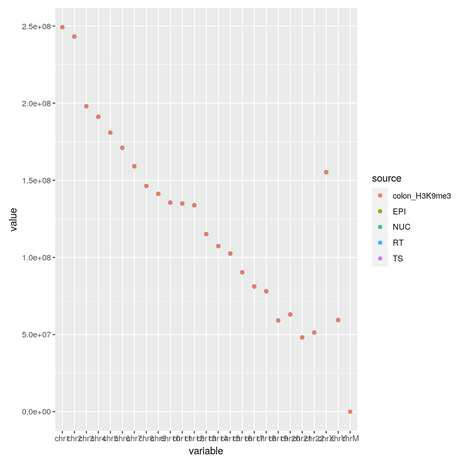

(more or less fully covered)
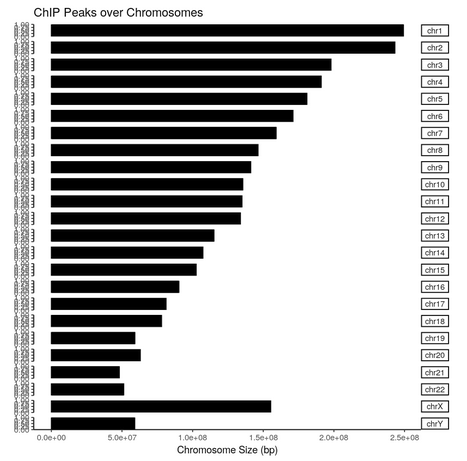

I can inspect the 'level' for each locus, and things look pretty normal.
`ChIPseeker::covplot(sample(colon_H3K9me3, 5000), weightCol="score")`
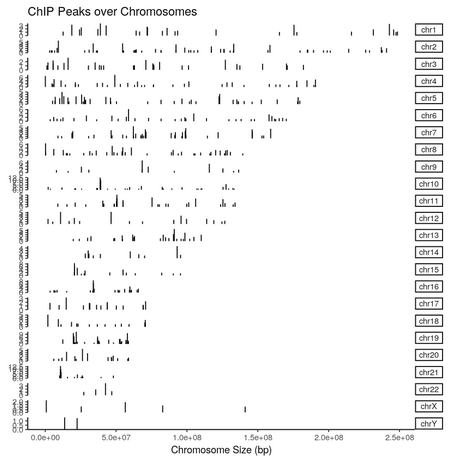

Use MC3 maf for sanity. PoisonAlien blesses me again with TCGAmutations package 

`ChIPseeker::covplot(mafRanges, weighCol = 't_alt_count')`

LUAD
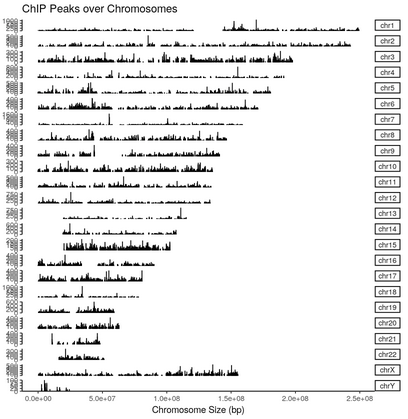

In [10]:
get_mafRanges <- function(maf){
    mafRanges <- maf@data %>%
        arrange(Chromosome, Start_Position, End_Position) %>%
        makeGRangesFromDataFrame(keep.extra.columns=T,
                                 ignore.strand=T,
                                 seqinfo=NULL,
                                 seqnames.field=c("Chromosome"),
                                 start.field="Start_Position",
                                 end.field=c("End_Position"),
                                 strand.field="strand",
                                 starts.in.df.are.0based=FALSE)
    seqlevelsStyle(mafRanges) <- "UCSC"
    seqlengths(mafRanges) <- seqlengths(TS)
    return(mafRanges)
}

In [17]:
get_counts <- function(data, tiles, new_col_name = 'count', as_granges = F){
    hits <- findOverlaps(tiles, data)
    counts <- hits %>% 
              as.data.frame() %>% 
              group_by(queryHits) %>% 
              summarize(subjectHits = n()) 

    counts <- counts$subjectHits[match(1:length(tiles), counts$queryHits)]
    counts <- ifelse(is.na(counts), 0, counts)
    if (as_granges){
        mcols(tiles)[[new_col_name]] <- counts
        return(tiles)
    }
    else{ return(counts) }
}

write_data_csv <- function(data, tiles, dest = 'data.csv'){
    mcols(get_counts(data, tiles))$count %>%
        t() %>% 
        write.table(file = dest, append = T, sep = ',', quote = F, col.names = F, row.names = F)
}

Ready to write out data. Tiles are not written, because they would just be removed anyway, then features (appending to file to keep memory down), and finally the number of mutations. 

In [18]:
tiles <- unlist(tileGenome(seqlengths(TS), tilewidth = WINDOW))

GRanges object with 3119 ranges and 0 metadata columns:
         seqnames            ranges strand
            <Rle>         <IRanges>  <Rle>
     [1]     chr1          1-999896      *
     [2]     chr1    999897-1999792      *
     [3]     chr1   1999793-2999688      *
     [4]     chr1   2999689-3999584      *
     [5]     chr1   3999585-4999480      *
     ...      ...               ...    ...
  [3115]     chrY 54374088-55373983      *
  [3116]     chrY 55373984-56373879      *
  [3117]     chrY 56373880-57373775      *
  [3118]     chrY 57373776-58373671      *
  [3119]     chrY 58373672-59373566      *
  -------
  seqinfo: 24 sequences from an unspecified genome

GRangesList object of length 30957:
[[1]]
GRanges object with 1 range and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1  1-100000      *
  -------
  seqinfo: 24 sequences from an unspecified genome

[[2]]
GRanges object with 1 range and 0 metadata columns:
      seqnames        ranges strand
         <Rle>     <IRanges>  <Rle>
  [1]     chr1 100001-199999      *
  -------
  seqinfo: 24 sequences from an unspecified genome

[[3]]
GRanges object with 1 range and 0 metadata columns:
      seqnames        ranges strand
         <Rle>     <IRanges>  <Rle>
  [1]     chr1 200000-299998      *
  -------
  seqinfo: 24 sequences from an unspecified genome

...
<30954 more elements>

In [22]:
p <- "https://egg2.wustl.edu/roadmap/data/byFileType/signal/consolidated/macs2signal/pval/"
bigwigs <- read.table('bigwigs.txt')$V1
sel <- grep(pattern = 'E075|E076|E0106|E092|E110|E111', x = bigwigs)
bigwigs[sel]

[1] "E075-H3K4me1.pval.signal.bigwig"  "E075-H3K4me3.pval.signal.bigwig" 
 [3] "E075-H3K9ac.pval.signal.bigwig"   "E075-H3K9me3.pval.signal.bigwig" 
 [5] "E075-H3K27ac.pval.signal.bigwig"  "E075-H3K27me3.pval.signal.bigwig"
 [7] "E075-H3K36me3.pval.signal.bigwig" "E076-H3K4me1.pval.signal.bigwig" 
 [9] "E076-H3K4me3.pval.signal.bigwig"  "E076-H3K9ac.pval.signal.bigwig"  
[11] "E076-H3K9me3.pval.signal.bigwig"  "E076-H3K27ac.pval.signal.bigwig" 
[13] "E076-H3K27me3.pval.signal.bigwig" "E076-H3K36me3.pval.signal.bigwig"
[15] "E092-DNase.pval.signal.bigwig"    "E092-H3K4me1.pval.signal.bigwig" 
[17] "E092-H3K4me3.pval.signal.bigwig"  "E092-H3K9me3.pval.signal.bigwig" 
[19] "E092-H3K27ac.pval.signal.bigwig"  "E092-H3K27me3.pval.signal.bigwig"
[21] "E092-H3K36me3.pval.signal.bigwig" "E110-H3K4me1.pval.signal.bigwig" 
[23] "E110-H3K4me3.pval.signal.bigwig"  "E110-H3K9ac.pval.signal.bigwig"  
[25] "E110-H3K9me3.pval.signal.bigwig"  "E110-H3K27me3.pval.signal.bigwig"
[27] "E110-H3K36me3.pval.signal.bigwig" "E111-H3K4me1.pval.signal.bigwig" 
[29] "E111-H3K4me3.pval.signal.bigwig"  "E111-H3K9ac.pval.signal.bigwig"  
[31] "E111-H3K9me3.pval.signal.bigwig"  "E111-H3K27ac.pval.signal.bigwig" 
[33] "E111-H3K27me3.pval.signal.bigwig" "E111-H3K36me3.pval.signal.bigwig"

In [23]:
epi <- paste0(p, bigwigs[sel])

hist_counts <- list()

for (datasource in epi){
    feature_gr <- rtracklayer::import(BigWigFile(datasource), selection = tiles)
    hist_counts[[datasource]] <- get_counts(feature_gr[mcols(feature_gr)$score > PEAK_THRESH], tiles)
    
}


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

In [24]:
targets = list()
studies = c('COAD', 'STAD')

for (s in studies){
    maf <- TCGAmutations::tcga_load(study = s)
    mafRanges <- get_mafRanges(maf)
    targets[[s]] <- get_counts(mafRanges, tiles)
}

Loading COAD. Please cite: https://doi.org/10.1016/j.cels.2018.03.002 for reference

`summarise()` ungrouping output (override with `.groups` argument)

Loading STAD. Please cite: https://doi.org/10.1016/j.cels.2018.03.002 for reference

`summarise()` ungrouping output (override with `.groups` argument)



In [25]:
# remove names so that not saved as dict
names(hist_counts) <- names(targets) <- NULL
np$savez('data_COAD_STAD_w1e6.npz', hist_counts=hist_counts, targets=targets)